# 📊 Sales Forecasting — Walmart (Kaggle)

**Project:** Task 7 — Sales Forecasting

**Short description:**
This Colab notebook demonstrates a complete, production-ready workflow to forecast weekly sales using the *Walmart Sales Forecasting* dataset (Kaggle). It includes data loading instructions, preprocessing, time-based feature engineering, lag features, exploratory data analysis (EDA), time-aware train/test split, model training (Linear Regression, XGBoost, LightGBM), evaluation (MAE, RMSE, R²), visualizations, and a bonus section for rolling averages, seasonal decomposition, and hyperparameter tuning.

> ⚠️ **Dataset note:** This notebook expects the Kaggle dataset files (`train.csv`, `features.csv`, `stores.csv`) to be uploaded to the Colab session or accessible via the Kaggle API. Instructions are provided in the "Load Dataset" section.

---


## Import Libraries

Below we import common data science libraries used in this project. If running in Google Colab, install missing libraries (instructions included).

In [1]:
# If you're running this in Google Colab uncomment & run the following cell to install missing libraries
# !pip install xgboost lightgbm statsmodels kaggle --quiet

import warnings
warnings.filterwarnings('ignore')

import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12,6)


## Load Dataset

Provide instructions to load dataset into Colab. Options:

1. **Upload files manually** (`train.csv`, `features.csv`, `stores.csv`).
2. **Use Kaggle API**: set up `kaggle.json` and download dataset programmatically.

After uploading, run the next cell to load and merge the data.

In [8]:
# --- Option A: If you already uploaded the files to the Colab session (files tab) ---
# Path examples: '/content/train.csv', '/content/features.csv', '/content/stores.csv'
train_path = '/content/train.csv'   # change if needed
features_path = '/content/features.csv'
stores_path = '/content/stores.csv'

if not (os.path.exists(train_path) and os.path.exists(features_path) and os.path.exists(stores_path)):
    print("One or more dataset files not found in the specified paths.\nPlease either upload 'train.csv', 'features.csv', 'stores.csv' to /content or use the Kaggle API.")
else:
    print('Files found. Ready to load.')




Files found. Ready to load.


### Load & preview the data

This cell loads the CSVs into pandas DataFrames and performs an initial merge to create a single table for modeling.

In [9]:
# Load CSVs (make sure paths are correct)
try:
    train = pd.read_csv(train_path)
    features = pd.read_csv(features_path)
    stores = pd.read_csv(stores_path)
except Exception as e:
    print('Error loading files:', e)
    # create empty placeholders to avoid notebook crash for preview
    train = pd.DataFrame()
    features = pd.DataFrame()
    stores = pd.DataFrame()

print('Train shape:', train.shape)
print('Features shape:', features.shape)
print('Stores shape:', stores.shape)

if not train.empty:
    display(train.head())
else:
    print('train.csv not loaded yet. Upload files and re-run this cell.')

Train shape: (421570, 5)
Features shape: (8190, 12)
Stores shape: (45, 3)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


## Data Preprocessing

Steps:
- Handle missing values
- Convert `Date` to `datetime`
- Merge datasets
- Basic cleaning


In [10]:
# Basic preprocessing & merge (if data exists)
if not train.empty:
    # Convert Date column to datetime
    train['Date'] = pd.to_datetime(train['Date'])
    features['Date'] = pd.to_datetime(features['Date'])

    # Merge datasets on Store, Date, and IsHoliday
    df = train.merge(features, on=['Store','Date','IsHoliday'], how='left')
    df = df.merge(stores, on='Store', how='left')

    print('Merged df shape:', df.shape)
    display(df.head())

    # Check missing values
    missing = df.isnull().sum().sort_values(ascending=False)
    display(missing[missing>0])

    # Simple missing value strategies (example)
    num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    for c in num_cols:
        df[c] = df[c].fillna(df[c].median())
    for c in cat_cols:
        df[c] = df[c].fillna('Unknown')

    print('\nAfter filling missing values:')
    display(df.isnull().sum().sum())
else:
    print('Dataframe empty — please upload dataset files and re-run the cells.')

Merged df shape: (421570, 16)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


,0
MarkDown2,310322
MarkDown4,286603
MarkDown3,284479
MarkDown1,270889
MarkDown5,270138



After filling missing values:


np.int64(0)

## Feature Engineering (Time-based & Lag Features)

Create time features and lag features (previous week sales, rolling averages). We will encode categorical variables and create lags per (Store, Dept) group.

In [13]:
# Feature engineering function
def create_time_features(df):
    df['day'] = df['Date'].dt.day
    df['week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['is_month_start'] = df['Date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['Date'].dt.is_month_end.astype(int)
    return df

def create_lag_features(df, group_cols=['Store','Dept'], target='Weekly_Sales', lags=[1,2,3,4,12], rolling_windows=[3,7,13]):
    df = df.sort_values(group_cols + ['Date']).copy()
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby(group_cols)[target].shift(lag)
    for w in rolling_windows:
        df[f'rolling_mean_{w}'] = df.groupby(group_cols)[target].shift(1).rolling(window=w, min_periods=1).mean()
    return df

if not train.empty:
    df = create_time_features(df)
    df = create_lag_features(df)

    # Encode categorical columns (Store & Dept)
    le_store = LabelEncoder()
    le_dept = LabelEncoder()
    df['Store_enc'] = le_store.fit_transform(df['Store'].astype(str))
    df['Dept_enc'] = le_dept.fit_transform(df['Dept'].astype(str))

    display(df[[ 'Store','Dept','Date','Weekly_Sales','lag_1','rolling_mean_3']].head(10))
else:
    print('No data — upload dataset first.')

,Store,Dept,Date,Weekly_Sales,lag_1,rolling_mean_3
0,1,1,2010-02-05,24924.50,NaN,NaN
1,1,1,2010-02-12,46039.49,24924.50,24924.500000
2,1,1,2010-02-19,41595.55,46039.49,35481.995000
3,1,1,2010-02-26,19403.54,41595.55,37519.846667
4,1,1,2010-03-05,21827.90,19403.54,35679.526667
5,1,1,2010-03-12,21043.39,21827.90,27608.996667
6,1,1,2010-03-19,22136.64,21043.39,20758.276667
7,1,1,2010-03-26,26229.21,22136.64,21669.310000
8,1,1,2010-04-02,57258.43,26229.21,23136.413333
9,1,1,2010-04-09,42960.91,57258.43,35208.093333


## EDA (Exploratory Data Analysis)

Visualize sales trends, store/department comparisons, and relationship with holidays.

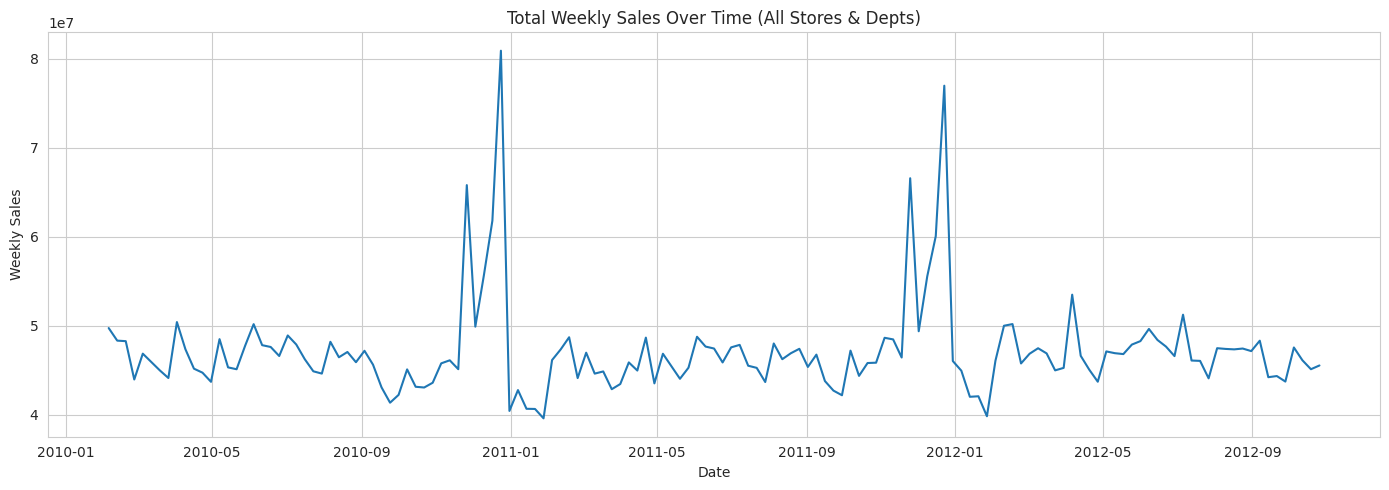

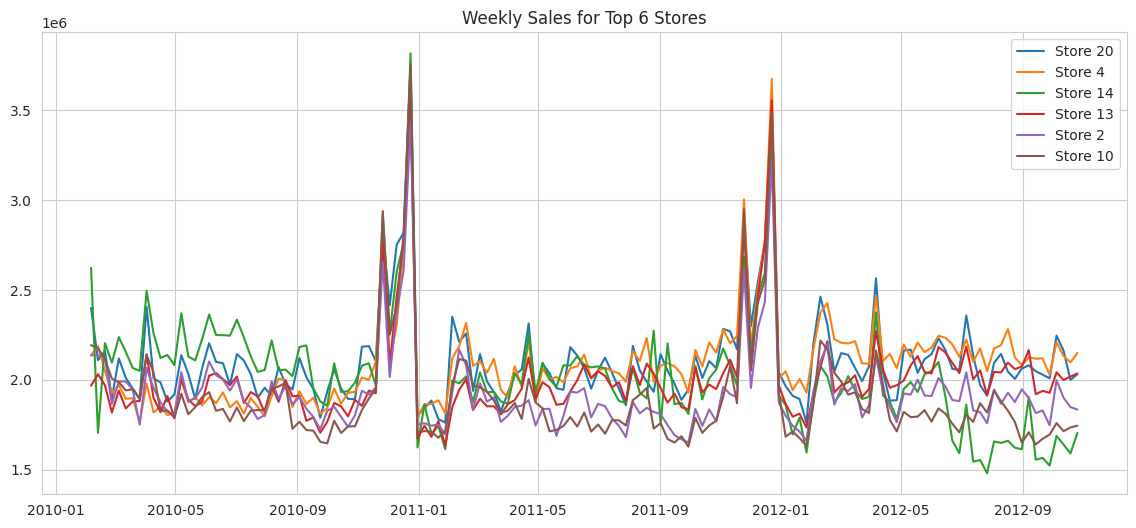

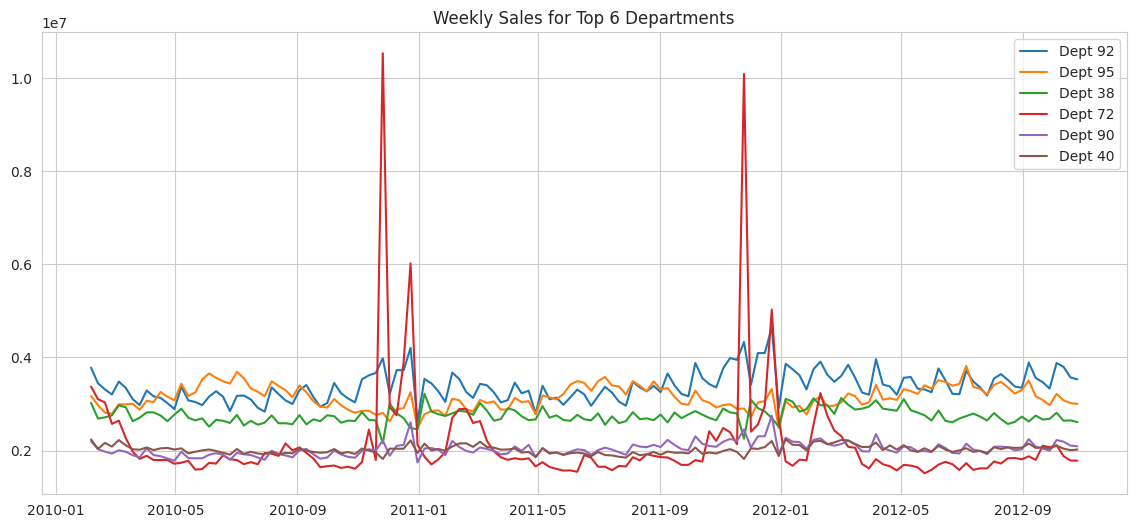

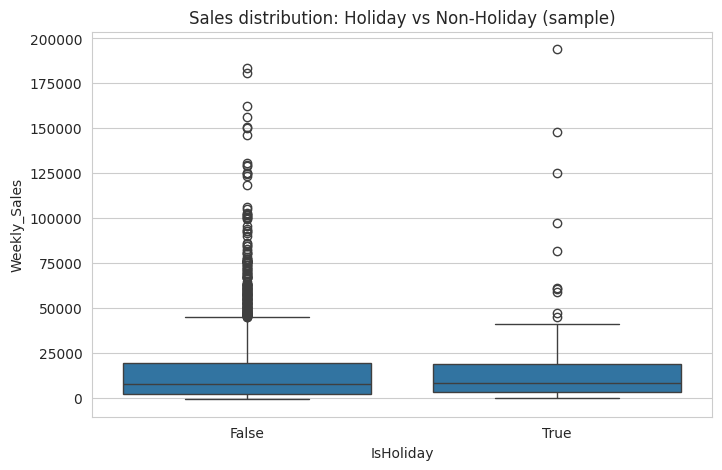

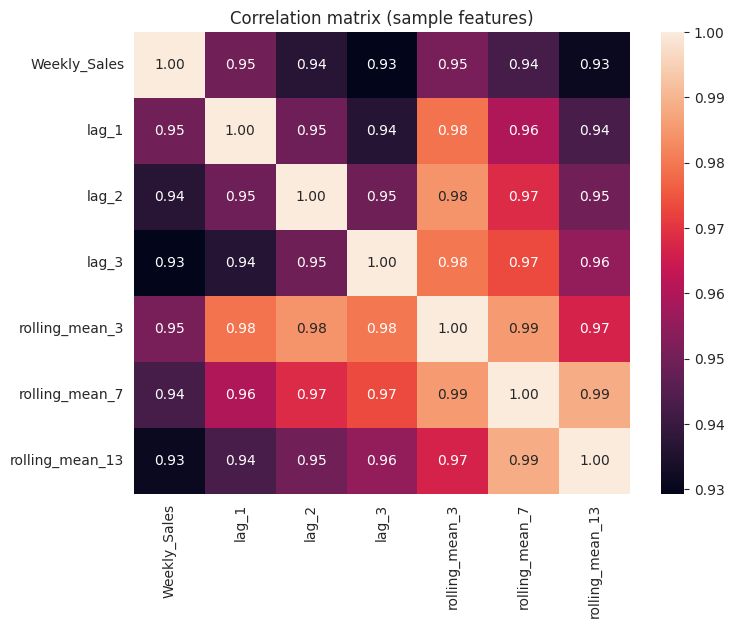

In [14]:
if not train.empty:
    # Simple sales over time (total weekly sales across all stores & departments)
    sales_ts = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
    plt.figure(figsize=(14,5))
    plt.plot(sales_ts['Date'], sales_ts['Weekly_Sales'])
    plt.title('Total Weekly Sales Over Time (All Stores & Depts)')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.tight_layout()
    plt.show()

    # Sales by store (sample top 6 stores)
    top_stores = df.groupby('Store')['Weekly_Sales'].sum().nlargest(6).index.tolist()
    plt.figure(figsize=(14,6))
    for s in top_stores:
        tmp = df[df['Store']==s].groupby('Date')['Weekly_Sales'].sum().reset_index()
        plt.plot(tmp['Date'], tmp['Weekly_Sales'], label=f'Store {s}')
    plt.legend()
    plt.title('Weekly Sales for Top 6 Stores')
    plt.show()

    # Sales by department (top 6)
    top_depts = df.groupby('Dept')['Weekly_Sales'].sum().nlargest(6).index.tolist()
    plt.figure(figsize=(14,6))
    for d in top_depts:
        tmp = df[df['Dept']==d].groupby('Date')['Weekly_Sales'].sum().reset_index()
        plt.plot(tmp['Date'], tmp['Weekly_Sales'], label=f'Dept {d}')
    plt.legend()
    plt.title('Weekly Sales for Top 6 Departments')
    plt.show()

    # Boxplot: sales on holiday vs non-holiday
    plt.figure(figsize=(8,5))
    sns.boxplot(x='IsHoliday', y='Weekly_Sales', data=df.sample(2000, random_state=42))
    plt.title('Sales distribution: Holiday vs Non-Holiday (sample)')
    plt.show()

    # Correlation heatmap for numeric features
    num_features = ['Weekly_Sales','lag_1','lag_2','lag_3','rolling_mean_3','rolling_mean_7','rolling_mean_13']
    num_features = [c for c in num_features if c in df.columns]
    corr = df[num_features].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt='.2f')
    plt.title('Correlation matrix (sample features)')
    plt.show()
else:
    print('No data for EDA — upload dataset and re-run.')

## Train-Test Split (time-aware)

We'll split by date: train on older dates and test on the most recent weeks. This avoids leakage for time series forecasting.

In [15]:
# Time-aware split: choose a cutoff date (e.g., last 16 weeks for test)
if not train.empty:
    cutoff_date = df['Date'].max() - pd.Timedelta(weeks=16)
    train_df = df[df['Date'] <= cutoff_date].copy()
    test_df = df[df['Date'] > cutoff_date].copy()
    print('Cutoff date:', cutoff_date.date())
    print('Train shape:', train_df.shape, 'Test shape:', test_df.shape)
else:
    print('No data — upload dataset first.')

Cutoff date: 2012-07-06
Train shape: (374203, 33) Test shape: (47367, 33)


## Model Training (Linear Regression, XGBoost, LightGBM)

We will train three models: a baseline Linear Regression and two tree-based models (XGBoost & LightGBM). To keep training time reasonable, we sample or use a subset (e.g., most frequent Store-Dept pairs) — options shown below.

In [21]:
# Select feature columns and prepare training matrices
if not train.empty:
    feature_cols = ['Store_enc','Dept_enc','day','week','month','year','dayofweek','is_month_start','is_month_end',
                    'lag_1','lag_2','lag_3','rolling_mean_3','rolling_mean_7','rolling_mean_13','Temperature','Fuel_Price','CPI','Unemployment']
    # Keep only columns that exist in df (some features may be missing depending on dataset version)
    feature_cols = [c for c in feature_cols if c in df.columns]
    print('Using features:', feature_cols)

    # Drop rows with NA in lag features (first rows per group)
    train_df_model = train_df.dropna(subset=feature_cols+['Weekly_Sales']).copy()
    test_df_model = test_df.dropna(subset=feature_cols+['Weekly_Sales']).copy()

    X_train = train_df_model[feature_cols]
    y_train = train_df_model['Weekly_Sales']
    X_test = test_df_model[feature_cols]
    y_test = test_df_model['Weekly_Sales']

    # Scale for Linear Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- Linear Regression ---
    lr = LinearRegression(n_jobs=-1)
    lr.fit(X_train_scaled, y_train)
    y_pred_lr = lr.predict(X_test_scaled)

    # --- XGBoost ---
    xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=6)
    xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)]) # Removed verbose
    y_pred_xgb = xgb.predict(X_test)

    # --- LightGBM ---
    lgbm = LGBMRegressor(n_estimators=500, learning_rate=0.05, num_leaves=31, random_state=42, n_jobs=6)
    lgbm.fit(X_train, y_train) # Removed early_stopping_rounds, verbose and eval_set
    y_pred_lgb = lgbm.predict(X_test)

    print('Models trained.')
else:
    print('No data — upload dataset first.')

Using features: ['Store_enc', 'Dept_enc', 'day', 'week', 'month', 'year', 'dayofweek', 'is_month_start', 'is_month_end', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_mean_7', 'rolling_mean_13', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
[0]	validation_0-rmse:19677.07294
[1]	validation_0-rmse:17746.20221
[2]	validation_0-rmse:16009.76022
[3]	validation_0-rmse:14468.49132
[4]	validation_0-rmse:13091.48266
[5]	validation_0-rmse:11855.50965
[6]	validation_0-rmse:10751.21025
[7]	validation_0-rmse:9766.59006
[8]	validation_0-rmse:8892.31140
[9]	validation_0-rmse:8110.42300
[10]	validation_0-rmse:7414.53863
[11]	validation_0-rmse:6808.67819
[12]	validation_0-rmse:6263.06338
[13]	validation_0-rmse:5789.10678
[14]	validation_0-rmse:5379.45446
[15]	validation_0-rmse:5022.87177
[16]	validation_0-rmse:4706.69941
[17]	validation_0-rmse:4446.55838
[18]	validation_0-rmse:4217.84778
[19]	validation_0-rmse:4021.52047
[20]	validation_0-rmse:3856.27304
[21]	validation_0-rmse:3713.30706


## Evaluation & Visualization

Compute MAE, RMSE, and R² for each model and plot actual vs predicted sales over time.

Evaluation on test set:
Linear Regression -> MAE: 1845.58, RMSE: 3430.68, R2: 0.9753
XGBoost -> MAE: 1327.23, RMSE: 2825.80, R2: 0.9833
LightGBM -> MAE: 1329.01, RMSE: 2831.32, R2: 0.9832


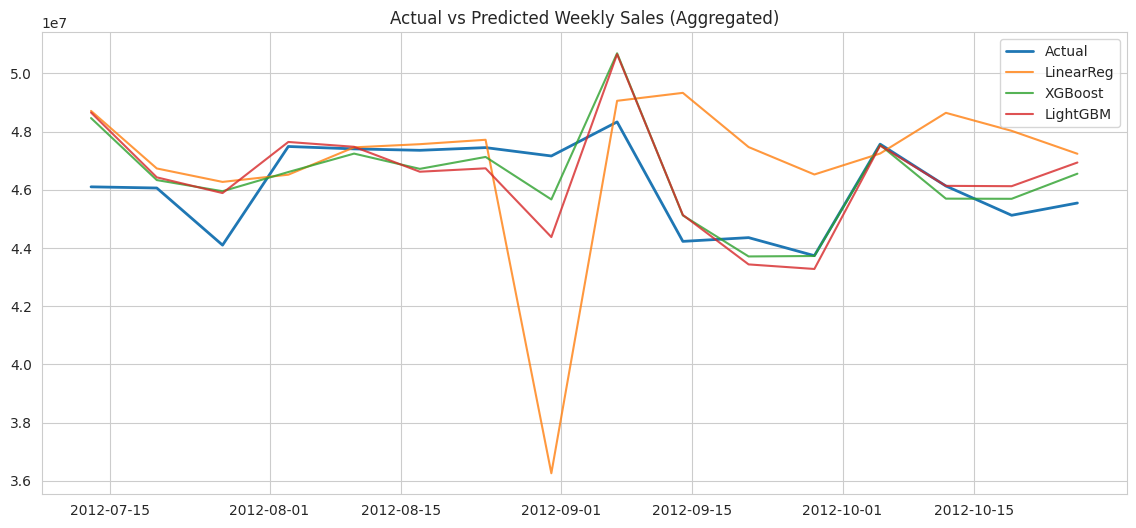

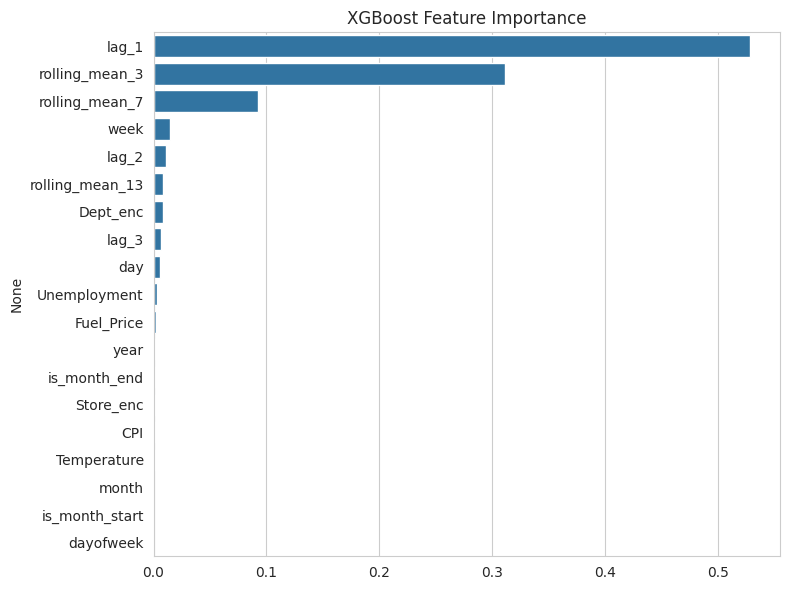

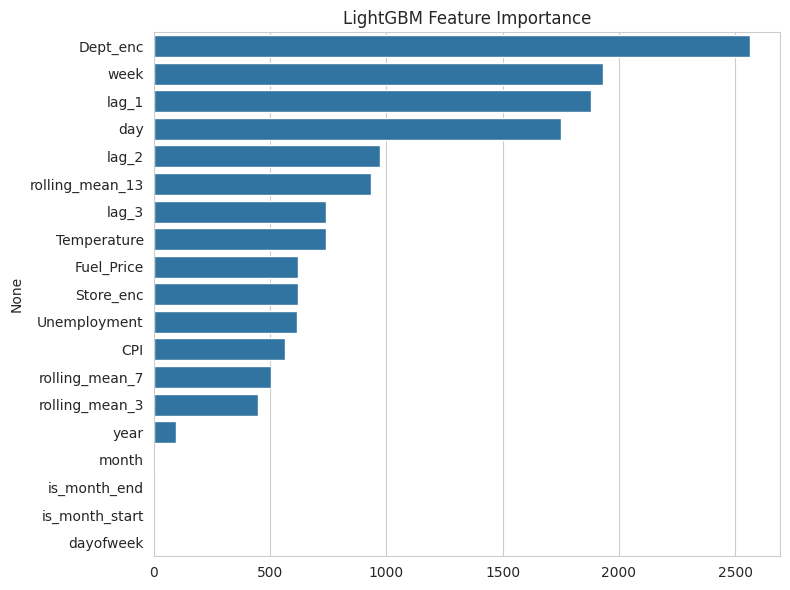

In [22]:
from math import sqrt

def evaluate(y_true, y_pred, model_name='Model'):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f'{model_name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}')
    return mae, rmse, r2

if not train.empty:
    print('Evaluation on test set:')
    eval_lr = evaluate(y_test, y_pred_lr, 'Linear Regression')
    eval_xgb = evaluate(y_test, y_pred_xgb, 'XGBoost')
    eval_lgb = evaluate(y_test, y_pred_lgb, 'LightGBM')

    # Add predictions to test_df for plotting
    test_df_model = test_df_model.copy()
    test_df_model['pred_lr'] = y_pred_lr
    test_df_model['pred_xgb'] = y_pred_xgb
    test_df_model['pred_lgb'] = y_pred_lgb

    # Aggregate weekly actual vs predicted across all stores & depts
    agg = test_df_model.groupby('Date')[['Weekly_Sales','pred_lr','pred_xgb','pred_lgb']].sum().reset_index()
    plt.figure(figsize=(14,6))
    plt.plot(agg['Date'], agg['Weekly_Sales'], label='Actual', linewidth=2)
    plt.plot(agg['Date'], agg['pred_lr'], label='LinearReg', alpha=0.8)
    plt.plot(agg['Date'], agg['pred_xgb'], label='XGBoost', alpha=0.8)
    plt.plot(agg['Date'], agg['pred_lgb'], label='LightGBM', alpha=0.8)
    plt.legend()
    plt.title('Actual vs Predicted Weekly Sales (Aggregated)')
    plt.show()

    # Feature importance for XGBoost and LightGBM
    def plot_feature_importance(model, features, top_n=20, model_name='Model'):
        try:
            fi = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)[:top_n]
            plt.figure(figsize=(8,6))
            sns.barplot(x=fi.values, y=fi.index)
            plt.title(f'{model_name} Feature Importance')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print('Could not plot feature importance for', model_name, e)

    plot_feature_importance(xgb, feature_cols, model_name='XGBoost')
    plot_feature_importance(lgbm, feature_cols, model_name='LightGBM')
else:
    print('No data — upload dataset first.')

## Bonus: Rolling Averages & Seasonal Decomposition

We compute rolling averages and apply seasonal decomposition (trend, seasonality, residuals) on aggregated series.

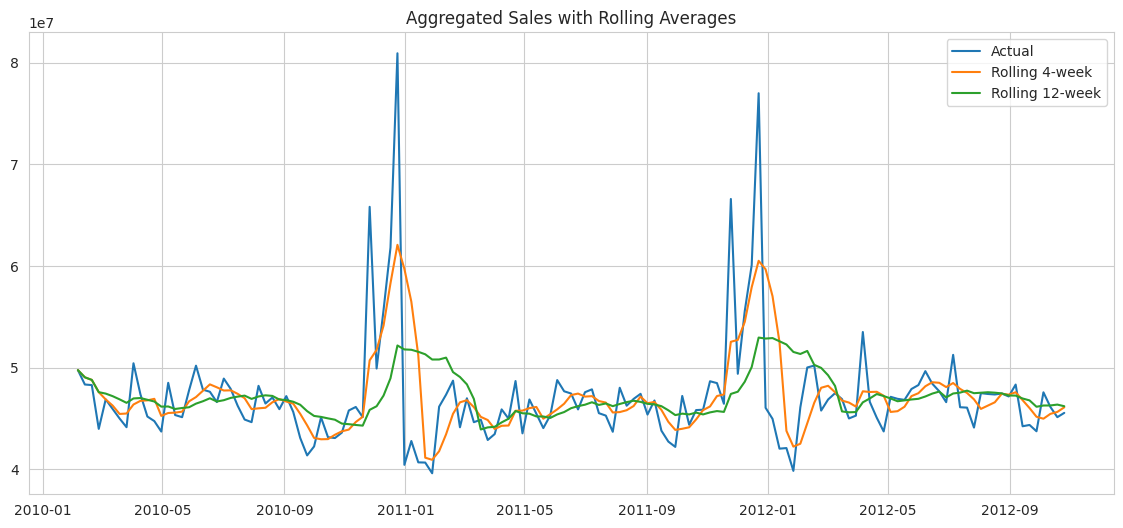

Shape of series before decomposition: (143,)
First 5 values of series: Date
2010-02-05    49750740.50
2010-02-12    48336677.63
2010-02-19    48276993.78
2010-02-26    43968571.13
2010-03-05    46871470.30
Freq: W-FRI, Name: Weekly_Sales, dtype: float64
Last 5 values of series: Date
2012-09-28    43734899.40
2012-10-05    47566639.31
2012-10-12    46128514.25
2012-10-19    45122410.57
2012-10-26    45544116.29
Freq: W-FRI, Name: Weekly_Sales, dtype: float64


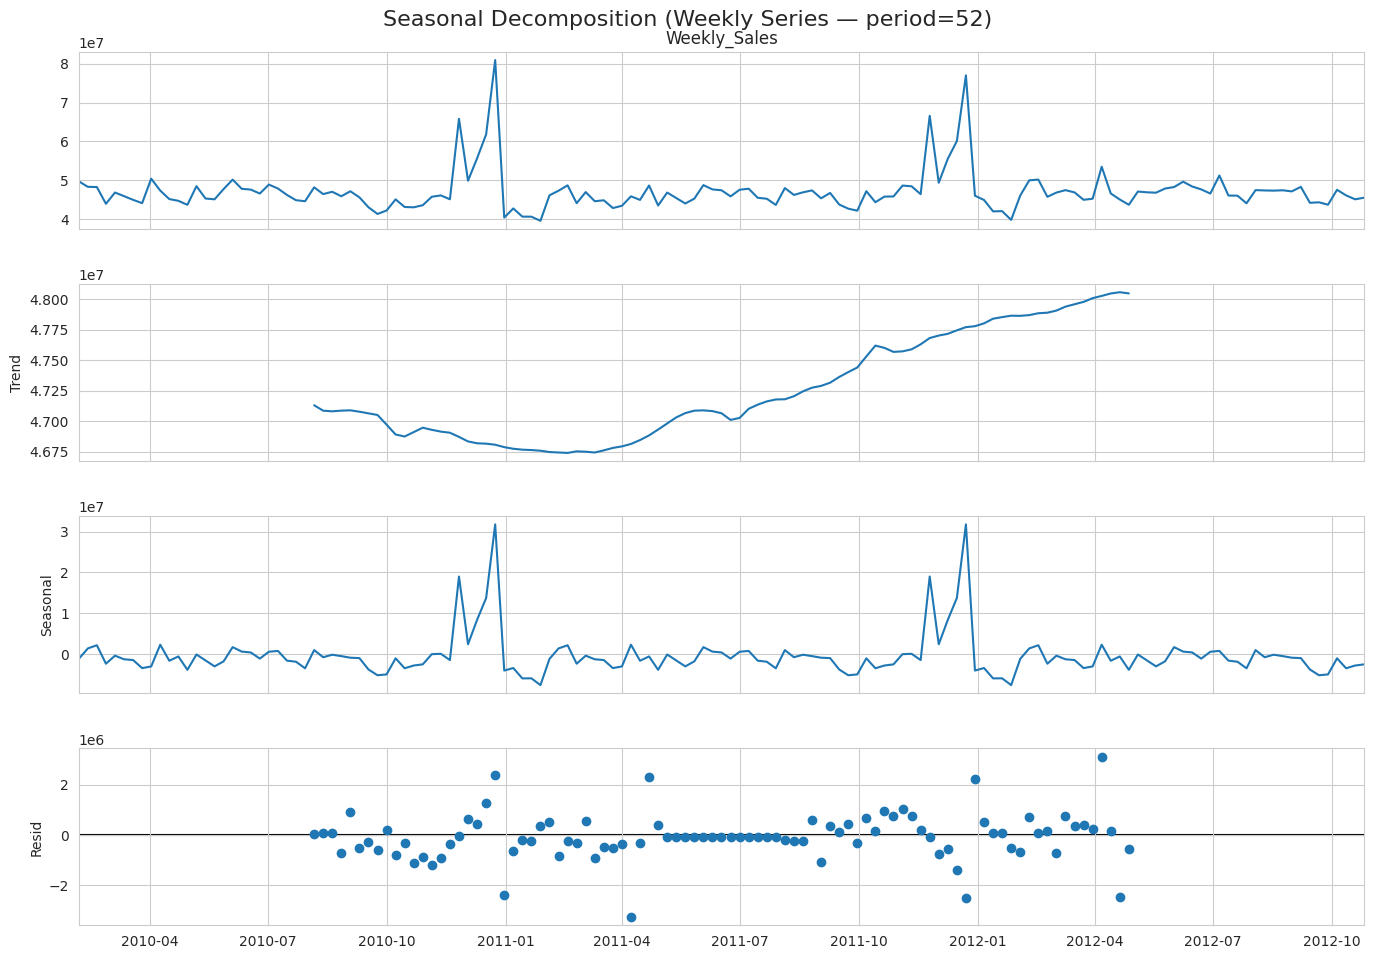

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params (XGBoost sample tuning): {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.1}


In [26]:
if not train.empty:
    # Rolling averages for the aggregated sales timeseries
    sales_ts = df.groupby('Date')['Weekly_Sales'].sum().reset_index().set_index('Date').asfreq('W-FRI') # Changed from 'W' to 'W-FRI'
    sales_ts['rolling_4'] = sales_ts['Weekly_Sales'].rolling(window=4, min_periods=1).mean()
    sales_ts['rolling_12'] = sales_ts['Weekly_Sales'].rolling(window=12, min_periods=1).mean()

    plt.figure(figsize=(14,6))
    plt.plot(sales_ts.index, sales_ts['Weekly_Sales'], label='Actual')
    plt.plot(sales_ts.index, sales_ts['rolling_4'], label='Rolling 4-week')
    plt.plot(sales_ts.index, sales_ts['rolling_12'], label='Rolling 12-week')
    plt.legend()
    plt.title('Aggregated Sales with Rolling Averages')
    plt.show()

    # Seasonal decomposition (additive)
    # Resample to weekly frequency if needed
    series = sales_ts['Weekly_Sales'].interpolate().dropna()
    print("Shape of series before decomposition:", series.shape) # Added print
    print("First 5 values of series:", series.head()) # Added print
    print("Last 5 values of series:", series.tail()) # Added print

    if series.shape[0] >= 104: # Added check for sufficient observations
      decomposition = seasonal_decompose(series, model='additive', period=52)
      fig = decomposition.plot()
      fig.set_size_inches(14,10)
      plt.suptitle('Seasonal Decomposition (Weekly Series — period=52)', fontsize=16)
      plt.show()
    else:
      print("Not enough data points (at least 104) for seasonal decomposition.") # Added message

    # Hyperparameter tuning example (RandomizedSearchCV) for XGBoost (small search for demo)
    param_dist = {
        'n_estimators': [100,200,400],
        'max_depth': [4,6,8],
        'learning_rate': [0.01,0.05,0.1],
        'subsample': [0.6,0.8,1.0]
    }
    rs = RandomizedSearchCV(XGBRegressor(random_state=42, n_jobs=6), param_distributions=param_dist,
                            n_iter=8, scoring='neg_mean_absolute_error', cv=3, verbose=1, random_state=42)
    # Use a reduced training sample for faster tuning demonstration
    sample_idx = np.random.choice(len(X_train), min(20000, len(X_train)), replace=False)
    rs.fit(X_train.iloc[sample_idx], y_train.iloc[sample_idx])
    print('Best params (XGBoost sample tuning):', rs.best_params_)
else:
    print('No data — upload dataset first.')

## Conclusion

This notebook provides a full pipeline for time-series sales forecasting using the Walmart dataset. It includes:

- Data loading and preprocessing
- Time-based and lag feature engineering
- EDA and insights
- Time-aware training and evaluation of Linear Regression, XGBoost, and LightGBM models
- Visualizations for results and model interpretability

**Next steps / improvements:**
- Train per-store or per-department models for better specialization
- Use more sophisticated CV strategies (walk-forward validation)
- Add external features (promotions, local events)
- Use ensembling or stacking for additional gains

Feel free to run this notebook in Google Colab. If you want, I can now upload this `.ipynb` file for you to download.
